 # Data Science Unit 2 Sprint Challenge 4 — Model Validation

Follow the instructions for each numbered part to earn a score of 2. See the bottom of the notebook for a list of ways you can earn a score of 3.

## Predicting Blood Donations

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive.

The goal is to predict the last column, whether the donor made a donation in March 2007, using information about each donor's history. We'll measure success using recall score as the model evaluation metric.

Good data-driven systems for tracking and predicting donations and supply needs can improve the entire supply chain, making sure that more patients get the blood transfusions they need.

#### Run this cell to load the data:

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')

df = df.rename(columns={
    'Recency (months)': 'months_since_last_donation', 
    'Frequency (times)': 'number_of_donations', 
    'Monetary (c.c. blood)': 'total_volume_donated', 
    'Time (months)': 'months_since_first_donation', 
    'whether he/she donated blood in March 2007': 'made_donation_in_march_2007'
})

In [2]:
df.head()
target = df["made_donation_in_march_2007"]

## Part 1.1 — Begin with baselines

What **accuracy score** would you get here with a **"majority class baseline"?** 
 
(You don't need to split the data into train and test sets yet. You can answer this question either with a scikit-learn function or with a pandas function.)

In [3]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
target.mode()
baseline = np.full(shape=target.shape, fill_value=target.mode())
mean_absolute_error(target, baseline)

0.23796791443850268

What **recall score** would you get here with a **majority class baseline?**

(You can answer this question either with a scikit-learn function or with no code, just your understanding of recall.)

#### Answer
the recall would be 1 for the 0 class and 0 for the 1 class. with an average recall of 1-.237

In [4]:
print(classification_report(target, baseline))

             precision    recall  f1-score   support

          0       0.76      1.00      0.86       570
          1       0.00      0.00      0.00       178

avg / total       0.58      0.76      0.66       748



C:\Users\cwcol\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Part 1.2 — Split data

In this Sprint Challenge, you will use "Cross-Validation with Independent Test Set" for your model evaluation protocol.

First, **split the data into `X_train, X_test, y_train, y_test`**, with random shuffle. (You can include 75% of the data in the train set, and hold out 25% for the test set.)


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(["made_donation_in_march_2007"],axis=1),target)
X_train.head()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation
195,2,5,1250,47
341,23,38,9500,98
235,8,10,2500,63
716,21,2,500,26
338,11,1,250,11


## Part 2.1 — Make a pipeline

Make a **pipeline** which includes:
- Preprocessing with any scikit-learn [**Scaler**](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
- Feature selection with **[`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)([`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html))**
- Classification with [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(RobustScaler(), SelectKBest(f_regression), LogisticRegression())



## Part 2.2 — Do Grid Search Cross-Validation

Do [**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) with your pipeline. Use **5 folds** and **recall score**.

Include these **parameters for your grid:**

#### `SelectKBest`
- `k : 1, 2, 3, 4`

#### `LogisticRegression`
- `class_weight : None, 'balanced'`
- `C : .0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0`


**Fit** on the appropriate data.

In [7]:
class_weight = [None,'balanced']
param_grid = {'selectkbest__k' : range(1,len(X_train.columns)+1), 
              'logisticregression__class_weight': class_weight,
              'logisticregression__C' : [0.0001, 0.001, 0.01, 1.0 ,1.0,10.0,100.0,1000.0,10000.0] }
gs = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring ='accuracy')

In [8]:
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_regression at 0x00000215D3554C80>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'selectkbest__k': range(1, 5), 'logisticregression__class_weight': [None, 'balanced'], 'logisticregression__C': [0.0001, 0.001, 0.01, 1.0, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

## Part 3 — Show best score and parameters

Display your **best cross-validation score**, and the **best parameters** (the values of `k, class_weight, C`) from the grid search.

(You're not evaluated here on how good your score is, or which parameters you find. You're only evaluated on being able to display the information. There are several ways you can get the information, and any way is acceptable.)

In [9]:
validation_score = gs.best_score_

In [134]:
print("best cross validation score:", gs.best_score_,"\n")
print("best C params: ", gs.best_params_["logisticregression__C"])
print("best SelectKBest params: ", gs.best_params_["selectkbest__k"])

best cross validation score: 0.7932263814616756 

best C params:  1.0
best SelectKBest params:  7


In [135]:
y_pred = gs.predict(X_test)

In [136]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.80      0.94      0.86       143
          1       0.55      0.25      0.34        44

avg / total       0.74      0.78      0.74       187



## Part 4 — Calculate classification metrics from a confusion matrix

Suppose this is the confusion matrix for your binary classification model:

<table>
  <tr>
    <th colspan="2" rowspan="2"></th>
    <th colspan="2">Predicted</th>
  </tr>
  <tr>
    <th>Negative</th>
    <th>Positive</th>
  </tr>
  <tr>
    <th rowspan="2">Actual</th>
    <th>Negative</th>
    <td>85</td>
    <td>58</td>
  </tr>
  <tr>
    <th>Positive</th>
    <td>8</td>
    <td>36</td>
  </tr>
</table>

Calculate accuracy

In [13]:
t = 85+58+36+8
s = (85+36)/t
print(s)

0.6470588235294118


accuracy is 64%

Calculate precision

In [14]:
n = 85/(85+8)
p=  36/(36+58)
print(n,"\n",p)

0.9139784946236559 
 0.3829787234042553


precision for negatives is 91%
precision for positives is 38%


Calculate recall

In [15]:
n = 85 / (85+58)
p = (36/44)
print(n,"\n",p)

0.5944055944055944 
 0.8181818181818182


recall for negatives is 59%
recall for positives is 82%

## BONUS — How you can earn a score of 3

### Part 1
Do feature engineering, to try improving your cross-validation score.

### Part 2
Add transformations in your pipeline and parameters in your grid, to try improving your cross-validation score.

### Part 3
Show names of selected features. Then do a final evaluation on the test set — what is the test score?

### Part 4
Calculate F1 score and False Positive Rate. 

### Feature engineering

In [16]:
X_train.head()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation
195,2,5,1250,47
341,23,38,9500,98
235,8,10,2500,63
716,21,2,500,26
338,11,1,250,11


In [71]:
def feature_engineering(X_train):
    X_train["active_months"] = X_train["months_since_first_donation"]- X_train["months_since_last_donation"]
    X_train["active_months"] = X_train["active_months"] +1
    X_train["donations_per_month"] = X_train["number_of_donations"] /X_train["active_months"]
    X_train["sqrt_months_since_last_donation"] = np.sqrt(X_train["months_since_last_donation"])
    X_train["sqrt_number_of_donations"]=np.sqrt(X_train["number_of_donations"])
    return X_train

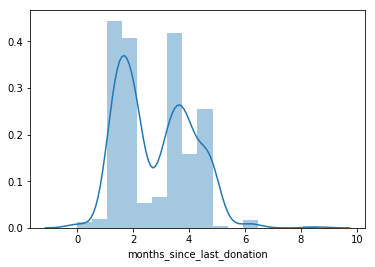

In [74]:
import seaborn as sns
sns.distplot(np.sqrt(X_train["months_since_last_donation"]))

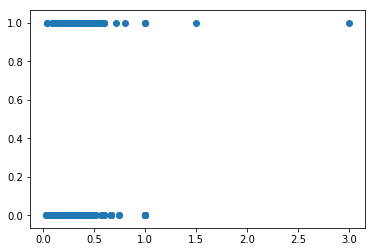

In [75]:
import matplotlib.pyplot as plt
plt.scatter(X_train["donations_per_month"],y_train)

In [76]:
from sklearn.decomposition import PCA

In [83]:
X_train_fe.columns

Index(['months_since_last_donation', 'number_of_donations',
       'total_volume_donated', 'months_since_first_donation', 'active_months',
       'donations_per_month', 'sqrt_months_since_last_donation',
       'sqrt_number_of_donations'],
      dtype='object')

In [97]:
range(1,len(X_train_fe.columns.values)+1)

range(1, 9)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(["made_donation_in_march_2007"],axis=1),target)
X_train_fe = feature_engineering(X_train)
X_test_fe  = feature_engineering(X_test)
pipe = make_pipeline(RobustScaler(), SelectKBest(f_regression), LogisticRegression())
class_weight = [{0:1,1:1}, {0:1,1:10},{0:1,1:25}, {0:1,1:100}]
param_grid = {'selectkbest__k' : range(1,len(X_train_fe.columns.values)), 
              'logisticregression__class_weight': class_weight,
              'logisticregression__C' : [1.0,10.0, 12.5, 25.,100.0,] }
gs = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring ='accuracy')
gs.fit(X_train_fe,y_train)
y_pred = gs.predict(X_test_fe)
print("best cross validation score:", gs.best_score_,"\n")
print("best C params: ", gs.best_params_["logisticregression__C"])
print("best SelectKBest params: ", gs.best_params_["selectkbest__k"])
print(classification_report(y_test,y_pred))

print("false positive rate: ")

best cross validation score: 0.7932263814616756 

best C params:  1.0
best SelectKBest params:  7
             precision    recall  f1-score   support

          0       0.80      0.94      0.86       143
          1       0.55      0.25      0.34        44

avg / total       0.74      0.78      0.74       187

false positive rate: 


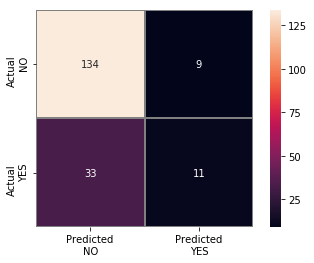

In [139]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)
def confusion_viz(y_true, y_pred):
    matrix = confusion_matrix(y_true,y_pred)
    return sns.heatmap(matrix, annot=True,
                      fmt=',', linewidths=1,linecolor='grey',
                      square=True,
                      xticklabels=['Predicted\nNO', 'Predicted\nYES'], 
                       yticklabels=['Actual\nNO', 'Actual\nYES'])
confusion_viz(y_test, y_pred)

In [140]:
print("false positive rate", 11/(11+134)) 

false positive rate 0.07586206896551724


In [119]:
import sklearn.feature_selection as fe
d = fe.SelectKBest(fe.mutual_info_regression, k=7).fit(X_train_fe, y_train)

C:\Users\cwcol\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [123]:
d_scores = pd.Series(data=d.scores_, name='d_scores')
for i in range(0,len(X_train_fe.columns.values)):
    print(X_train.columns.values[i])
    print(d_scores[i],"\n")


months_since_last_donation
0.058125578236169595 

number_of_donations
0.03560639453530268 

total_volume_donated
0.04309113779824614 

months_since_first_donation
0.052028520153594826 

active_months
0.04063397067393115 

donations_per_month
0.0 

sqrt_months_since_last_donation
0.050534906911157584 

sqrt_number_of_donations
0.08690550830259713 



7 best features are everything but donation volume, probably becuase it is just a scalar of number of donations.